In [32]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
import poppy
import numba
from numba import jit

# Propogate Divergence & Waist Rays of Gaussian Beamlets - NONastigmatic beamlets

# System Parameters
wl     = 2.2e-6  # wavelength
d      = 5e-2        # propagation distance
f      = 1e50     # focal length
n      = 1         # refractive index (add support later)
sample = 1024       # number of detector pixels across
amax   = 5e-3     # maximum aperture radius
amin   = 0      # minimum aperture radius

# Configure system matrix - one grid of waist rays, one grid of divergence rays?
OF = 2    # overlap factor
W  = 2*amax # width of grid
N  = 625   # number of beams zacross the grid

# Preliminary calculations
gs = (W/N)*OF         # grid spacing, also the beam waist @origin
wo = gs               # beam waist = grid spacing
Zr = (np.pi*wo**2)/wl # Rayleigh range
k  = 2*np.pi/wl

d = .9*Zr

print(amax**2 / (d*wl),'Fresnel Number')
print(wo,'meter Beam Waist')
print(wo/wl,'waves')

8634.708284065502 Fresnel Number
3.2e-05 meter Beam Waist
14.545454545454543 waves
Wall time: 998 µs


In [33]:
%%time
# Configure system ABCD Matrix -> these become optical elements in future revisions
focus = np.array([[1,0],
                  [-1/f,1]])

propg = np.array([[1,d],
                  [0,1]])

# Calculate system ABCD Matrix
system = np.matmul(propg,focus) # CHECK PROPER MULTIPLICATION ORDER

# Define waist ray - unit height, no anlge
waist = np.array([[1]
                 ,[0]]) # top element is y, bottom element is w

# Define divergence ray - unit height, divergence angle!
divge = np.array([[1],
                  [wl/(np.pi*n*wo)]]) # this is a ray SLOPE, tan(angle)

# Predefine empty array for ray distribution - gonna put x & y components of rays here
x = np.linspace(-W,W,N)
y = np.linspace(W,-W,N)
x,y = np.meshgrid(x,y)

Wall time: 8.99 ms


In [34]:
%%time
# Create some empty boxes to throw our waist * divergence vectors into
pwx = np.zeros([N,N],dtype=object)
pdx = np.zeros([N,N],dtype=object)
pwy = np.zeros([N,N],dtype=object)
pdy = np.zeros([N,N],dtype=object)

# Create x & y arrays of waist & divergence rays
for ijk in range(N):
    for lmn in range(N):
        # Generate scale matricies
        scalex = np.array([[x[ijk,lmn],0],[0,1]])
        scaley = np.array([[y[ijk,lmn],0],[0,1]])
        
        # Place our ray vectors in a box
        pwx[ijk,lmn] = waist*(x[ijk,lmn]) # creates the waist ray
        pwy[ijk,lmn] = waist*(y[ijk,lmn])
        pdx[ijk,lmn] = np.matmul(scalex,divge) # creates divergence ray
        pdy[ijk,lmn] = np.matmul(scaley,divge)


Wall time: 5.68 s


In [35]:
%%time
# Create some empty boxes to throw our waist * divergence PROPOGATED vectors into
imgwx = np.zeros([N,N],dtype=object)
imgdx = np.zeros([N,N],dtype=object)
imgwy = np.zeros([N,N],dtype=object)
imgdy = np.zeros([N,N],dtype=object)

# Propagate waist & divergence rays
for abc in range(N):
    for xyz in range(N):
        imgwx[abc,xyz] = np.matmul(system,pwx[abc,xyz])
        imgdx[abc,xyz] = np.matmul(system,pdx[abc,xyz])
        imgwy[abc,xyz] = np.matmul(system,pwy[abc,xyz])
        imgdy[abc,xyz] = np.matmul(system,pdy[abc,xyz])
        

Wall time: 3.56 s


In [36]:
%%time
# Determine the distance traveled by each ray
Rbox = np.zeros([N,N]) # Store beam radii of curvature
tbox = np.zeros([N,N]) # store propagation distance of each beamlet

for tx in range(N):
    for ty in range(N):
        
        # Store propagated waists
        wtxpars = imgwx[tx,ty]
        wtypars = imgwy[tx,ty]
        
        # Store original waists
        woxpars = pwx[tx,ty]
        woypars = pwy[tx,ty]
        
        # Compute difference in thickness between waist positions
        tpars = np.sqrt((wtxpars[0,0]-woxpars[0,0])**2 + (wtypars[0,0]-woypars[0,0])**2 + d**2)
        tbox[tx,ty] = tpars
        Rbox[tx,ty] = tpars*(1+(Zr/tpars)**2) # calculate radii of curvature

        # Calculate resultant beam waists
wp = np.zeros([N,N])
for wpx in range(N):
    for wpy in range(N):
        imgwx_pars = imgwx[wpx,wpy]
        imgdx_pars = imgdx[wpx,wpy]
        imgwy_pars = imgwy[wpx,wpy]
        imgdy_pars = imgdy[wpx,wpy]
        wp[wpx,wpy] = wo*np.sqrt(1+(tbox[wpx,wpy]/Zr)**2)
        
print(wtxpars)
print(woxpars)
print(wtypars)
print(woypars)

[[ 1.e-02]
 [-1.e-52]]
[[0.01]
 [0.  ]]
[[-1.e-02]
 [ 1.e-52]]
[[-0.01]
 [-0.  ]]
Wall time: 3.33 s


In [37]:
%%time
# Now we have a grid of radii and a grid of waist sizes, lets-a plot some-a beamses

# Define Sample Plane
u = np.linspace(-W,W,sample)
v = np.linspace(-W,W,sample)
u,v = np.meshgrid(u,v)
afield = np.zeros([sample,sample]) # define analysis box


for px in range(N):
    for py in range(N):
        
        # Grab analysis x & y comps from waist for beam location
        imguv_parsx = imgwx[px,py] 
        imguv_parsy = imgwy[px,py]

        if np.sqrt(x[px,py]**2 + y[px,py]**2) <= amax and np.sqrt(x[px,py]**2 + y[px,py]**2) >= amin:
            p = np.square(u-imguv_parsx[0,0]) + np.square(v-imguv_parsy[0,0]) # define squared radial coord
            
            realker = -p/(wp[px,py])**2
            imagker = -1j*(k*tbox[px,py] + k*(p/(2*Rbox[px,py]))-np.arctan(tbox[px,py]/Zr))
            
            #realexp = ne.evaluate('exp(realker)')
            #imagexp = ne.evaluate('exp(imagker)')
            
            #ne.evaluate('exp(float_value*arr)')
            realexp = np.exp(-p/(wp[px,py])**2)
            imagexp = np.exp(-1j*(k*tbox[px,py] + k*(p/(2*Rbox[px,py]))-np.arctan(tbox[px,py]/Zr)))
            amptude = wo/wp[px,py]
            afield = afield + amptude*realexp*imagexp 
            
            

KeyboardInterrupt: 

KeyboardInterrupt: 

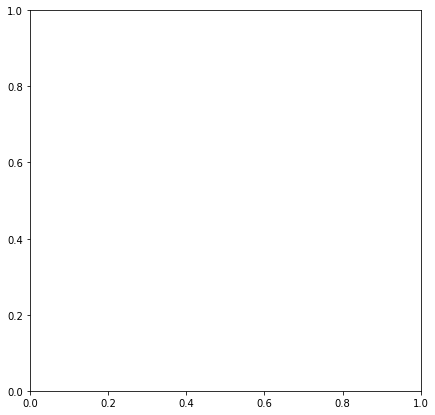

In [38]:
# Plot the afield var
Ifield = (np.real(afield*np.conj(afield)))
halfsamp = int(sample/2)
plt.figure(figsize=[7,7])
plt.pcolor(u,v,Ifield)
plt.colorbar()
plt.show()

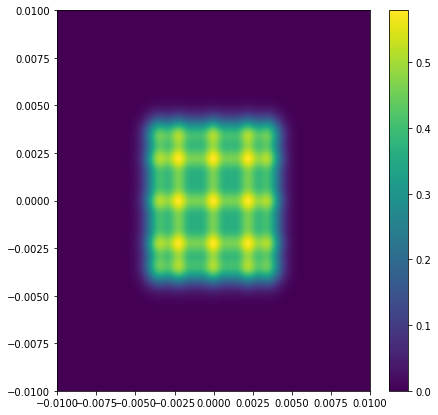

In [8]:
# Plot the afield var
Ifield = (np.real(afield*np.conj(afield)))
halfsamp = int(sample/2)
plt.figure(figsize=[7,7])
plt.pcolor(u,v,Ifield)
plt.colorbar()
plt.show()

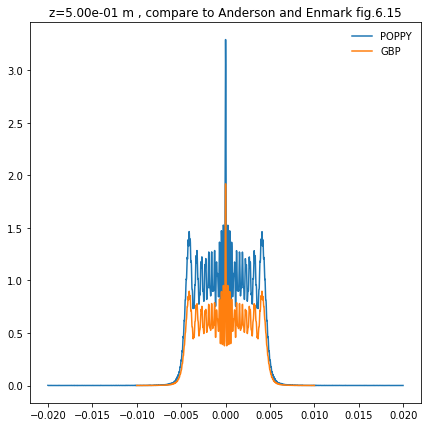

In [61]:
import poppy
import astropy.units as u
from poppy import fresnel
from poppy import optics
from poppy import poppy_core
from poppy import misc
from poppy import utils
from poppy.poppy_core import _log, PlaneType

import matplotlib.pyplot as plt
import numpy as np
from poppy import fwcentroid
from scipy.ndimage import zoom,shift

z = 5e-1*u.m

# the following points were traced/digitized using GraphClick from
# the published figure 6.15 by Anderson and Enmark. Beware of limited precision!
ref_x = [-0.505, -0.412, -0.368, -0.323, -0.302, -0.027, 0]
ref_y = [ 0.233,  1.446,  0.757,  1.264,  0.784,  1.520, 3.134]
npix = 512

proper_x = [0]
proper_y = [3.30790] # from high res sim: 16384**2 pix, beam ratio=0.125

if npix< 512:
    raise ValueError('npix too low for reasonable accuracy')
elif npix>=512 and npix < 1024:
    tolerance=0.02
elif npix>=1024 and npix<2048:
    # for some strange reason, 1024 pix does relatively worse than 512, assuming oversample=4
    tolerance = 0.035
else:
    tolerance=0.03

# Note there is a slight error in the text of Anderson and Enmark; the
# paragraph just before Fig 6.15 says "diameter D=0.5 m", but the
# figure actually depicts a case with radius r=0.5 m, as is immediately
# and obviously the case based on the x axis of the figure.

gw = fresnel.FresnelWavefront(beam_radius=5e-3*u.m,wavelength=2200e-9,npix=npix,oversample=4)
gw *= optics.CircularAperture(radius=5e-3,oversample=gw.oversample)

gw.propagate_fresnel(z)
inten = gw.intensity

y, x = gw.coordinates()


plt.figure(figsize=[7,7])
plt.plot(x[0,:], inten[inten.shape[1]//2,:], label='POPPY')
plt.title("z={:0.2e} , compare to Anderson and Enmark fig.6.15".format(z))

u = np.linspace(-W,W,sample)
plt.plot(u,Ifield[halfsamp,:],label="GBP")
plt.legend(loc='upper right', frameon=False)



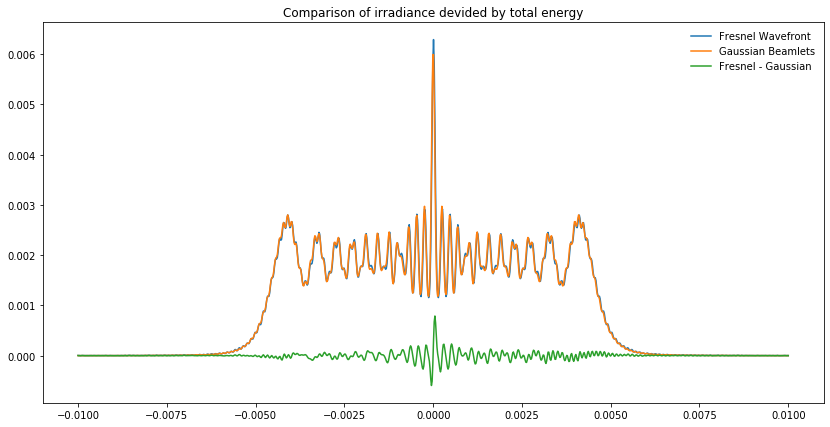

In [62]:
# Problem is - GBP & Poppy have different amounts of energy, we need to equate the sums
pars_inten = inten[inten.shape[1]//2,:]
pars_inten = pars_inten[512:1536]
fw = pars_inten/sum(pars_inten)
#fw = inten[inten.shape[1]//2,:]/sum(inten[inten.shape[1]//2,:])
gw = Ifield[halfsamp,:]/sum(Ifield[halfsamp,:])

xg = np.linspace(-W,W,sample)

plt.figure(figsize=[14,7])
plt.title("Comparison of irradiance devided by total energy")
plt.plot(xg,fw,label='Fresnel Wavefront')
plt.plot(xg,gw,label='Gaussian Beamlets')
plt.plot(xg,fw-gw,label='Fresnel - Gaussian')
plt.legend(loc='upper right', frameon=False)
plt.show()

In [ ]:
import numpy as np

hb = 1.05*10**(-34)
me = 9.1*10**(-31)
a = 0.7*10**(-9)

Vo = (((np.pi*hb)/((a)))**2)/(2*me)
print(Vo*6.242e+18)

lam = .5e-6
d = (.25e-3)/2 #+ .04e-3
th = np.arcsin(lam/d)
sp = np.tan(th)*100e-2
print(sp)
print(lam*100e-2 / d) # this is right

print(np.arcsin(1/1.49)*(180/np.pi))

In [10]:
n1 = 1.514
d  = 105.1
print(546/4)
print(n1*d*np.cos(30*np.pi/180))

136.5
137.80317468574518
